In [1]:
from bsoid_kit import *
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def assign_label(feat, motions, motion_score, treatment, usage='clf'):
    labels = np.zeros_like(motions, dtype=float)
    ms = motion_score.copy()
    if usage=='clf':
        if treatment == 'pH5.2':
            ms[np.where(motion_score==1)]=2
        elif treatment == 'pH7.4':
            ms[np.where(motion_score==1)]=0
    elif usage=='reg1':
        # treat => ms = 1*ms
        if treatment == 'basal' or treatment == 'pH7.4':
            ms=(-1)*(1-ms)
    elif usage=='clf_dir':
        if treatment == 'pH5.2':
            labels = [2]*len(feat)
        if treatment == 'Cap':
            labels = [1]*len(feat)
        return np.array(labels)
    for i in range(len(ms)):
        labels[np.where(motions==i)] = ms[i]
    return labels

In [7]:
# read all features, motions and corresponding treatment
root = r'./new_bsoidfeat/'
feature_embed = False
train_type = 'clf_dir'
motion_score=[]
motions=[]

x = []
y = []
treatments = []
files = os.listdir(root)
for file in files:
    savfile = joblib.load(root+'/'+file)
    if feature_embed:
        feat = savfile[1]
    else:
        feat = savfile[0]
    motions = savfile[-1]
    x.append(feat)
    treatment = file.split('-')[0]
    if file.find('basal')!=-1:
        if(train_type=='clf' or train_type=='clf_dir'):
            y.append(np.array([0]*len(feat)))
        else:
            y.append(assign_label(feat, motions, motion_score, 'basal', train_type))
        treatments.append(treatment+'basal')
    else:
        y.append(assign_label(feat, motions, motion_score, treatment, train_type))
        treatments.append(treatment)
feat_dim = x[0].shape[1]
x=np.array(x,dtype=object)
y=np.array(y,dtype=object)

In [12]:
# data index of different treatments
basal_ind = [i for i, j in enumerate(treatments) if j.find('basal')!=-1]
pain_ind = [i for i, j in enumerate(treatments) if j == 'Cap']
sng_ind = [i for i, j in enumerate(treatments) if j == 'pH5.2']
ro_ind = [i for i, j in enumerate(treatments) if j == 'pH7.4']
basalcap_ind = [i for i, j in enumerate(treatments) if j.find('Capbasal')!=-1]
# setting training set index
trainset = list(set(basalcap_ind) | set(pain_ind))

In [15]:
# train test split
x_trains = []
y_trains = []
for i in range(len(x)):
    feat = x[i]
    label = y[i]

    if i in trainset:
        sp = len(feat)
        x_trains.append(feat[:sp,:])
        y_trains.append(label[:sp])

x_train = np.concatenate([x for x in x_trains if len(x) != 0])
y_train = np.concatenate([y for y in y_trains if len(y) != 0])

In [16]:
model = SVC(kernel='rbf', C=1000)
model = model.fit(x_train,y_train)

In [17]:
from sklearn.inspection import permutation_importance

In [ ]:
result = permutation_importance(
    model, x_train,y_train, n_repeats=10, random_state=42, n_jobs=2
)

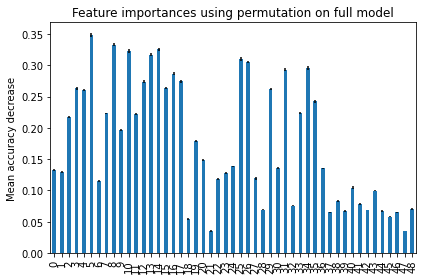

In [21]:
importances = pd.Series(result.importances_mean, index=np.arange(len(x_train[0])))
fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [27]:
np.where(result.importances_mean>0.3) 

(array([ 5,  8, 10, 13, 14, 25, 26], dtype=int64),)